In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

In [2]:
# Load data
data_ii = pd.read_csv('best_ball_mania_ii.csv')
data_iii = pd.read_csv('best_ball_mania_iii.csv')
data_iv = pd.read_csv('best_ball_mania_iv.csv')

In [3]:
print(data_ii.shape, data_iii.shape, data_iv.shape)

(216000, 15) (216000, 17) (216000, 19)


In [4]:
# Average 'roster_points' for each dataset
print(data_ii['pick_points'].mean())
print(data_iii['pick_points'].mean())
print(data_iv['pick_points'].mean()*4.5)

82.7876287962963
84.7998736111111
84.52989291666667


In [5]:
# Increase 'roster_points' and 'pick_points' for dataset iv by 4.5
data_iv['pick_points'] = data_iv['pick_points']*4.5
data_iv['roster_points'] = data_iv['roster_points']*4.5

# Columns that are in all datasets
cols = list(set(data_ii.columns) & set(data_iii.columns) & set(data_iv.columns))

# Filter columns
data_ii = data_ii[cols]
data_iii = data_iii[cols]
data_iv = data_iv[cols]

# Concatenate data
data = pd.concat([data_ii, data_iii, data_iv], axis=0)

In [6]:
# New column team_id which is the concatenation of 'roster_points' and 'draft_id'
data['team_id'] = data['roster_points'].astype(str) + '_' + data['draft_id'].astype(str)

data = data.drop(columns=['clock', 'tournament_round_number', 'bye_week', 'draft_time', 'tournament_entry_id'])

# Fit a polynomial regression
p = np.poly1d(np.polyfit(data['overall_pick_number'], data['pick_points'], 2))
data['poly_points'] = p(data['overall_pick_number'])

data.head()

,projection_adp,draft_id,pick_points,position_name,roster_points,player_name,overall_pick_number,playoff_team,team_pick_number,pick_order,team_id,poly_points
0,139.48,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,31.2,WR,1613.92,Jalen Reagor,144,0,12,1,1613.92_00009a0e-b1a6-42e0-b1cf-3f884cc0999b,56.807847
1,107.46,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,81.9,WR,1525.06,Marquez Callaway,115,0,10,6,1525.06_00009a0e-b1a6-42e0-b1cf-3f884cc0999b,71.483802
2,31.75,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,116.3,WR,1525.06,Amari Cooper,30,0,3,6,1525.06_00009a0e-b1a6-42e0-b1cf-3f884cc0999b,136.299426
3,171.55,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,66.5,RB,1669.72,Rhamondre Stevenson,158,1,14,11,1669.72_00009a0e-b1a6-42e0-b1cf-3f884cc0999b,51.077240
4,201.35,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2.8,RB,1669.72,Darrynton Evans,203,1,17,11,1669.72_00009a0e-b1a6-42e0-b1cf-3f884cc0999b,38.630469


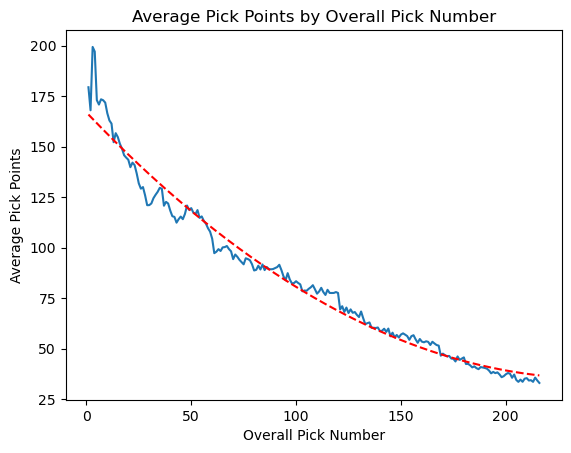

In [7]:
# Group by 'overall_pick_number' and average 'pick_points'
data_grouped = data.groupby('overall_pick_number').mean().reset_index()

# Plot
plt.plot(data_grouped['overall_pick_number'], data_grouped['pick_points'])
plt.plot(data_grouped['overall_pick_number'], data_grouped['poly_points'], 'r--')
plt.xlabel('Overall Pick Number')
plt.ylabel('Average Pick Points')
plt.title('Average Pick Points by Overall Pick Number')
plt.show()

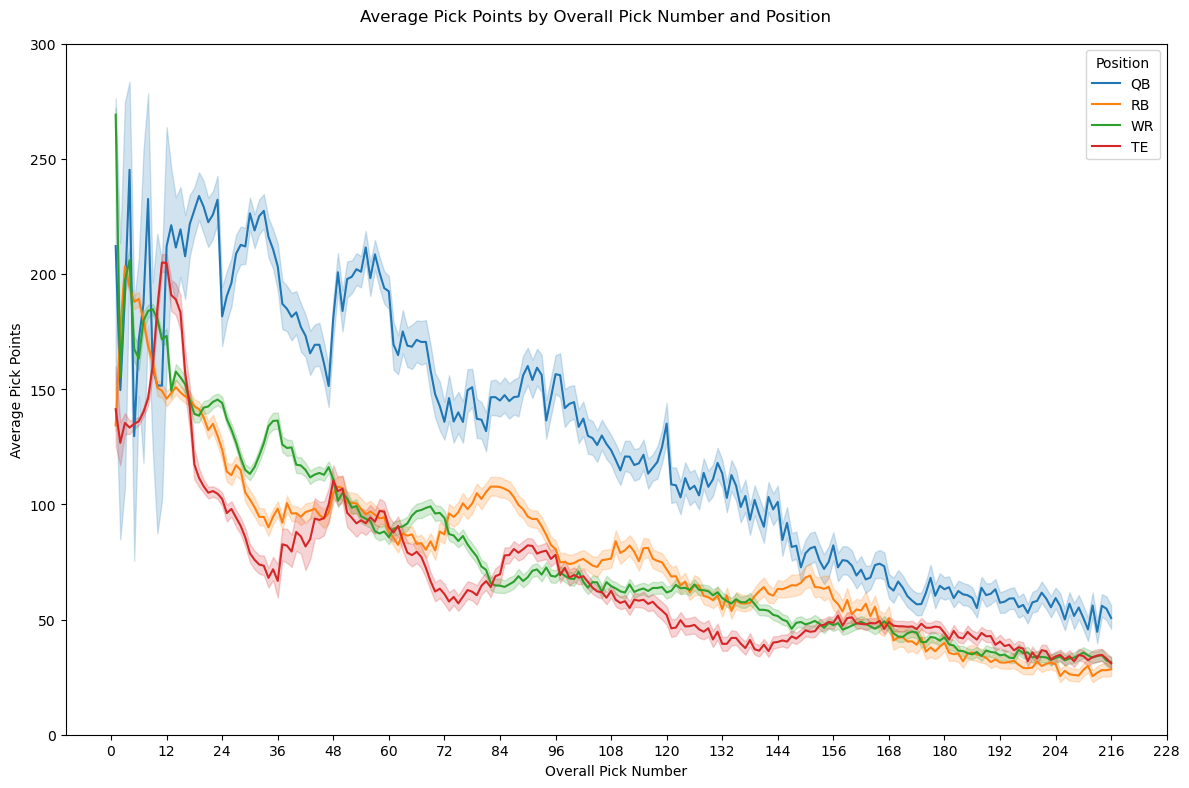

In [55]:
# Reset the index of the DataFrame
data_reset = data.reset_index()

# Plot each position on the same plot
plt.figure(figsize=(12, 8))
plt.suptitle('Average Pick Points by Overall Pick Number and Position')

sns.lineplot(data=data_reset[data_reset['position_name'] == 'QB'], x='overall_pick_number', y='pick_points', ci=95, label='QB')
sns.lineplot(data=data_reset[data_reset['position_name'] == 'RB'], x='overall_pick_number', y='pick_points', ci=95, label='RB')
sns.lineplot(data=data_reset[data_reset['position_name'] == 'WR'], x='overall_pick_number', y='pick_points', ci=95, label='WR')
sns.lineplot(data=data_reset[data_reset['position_name'] == 'TE'], x='overall_pick_number', y='pick_points', ci=95, label='TE')

plt.ylabel('Average Pick Points')
plt.xlabel('Overall Pick Number')
plt.ylim(0, 300)
plt.xticks(np.arange(0, 240, 12))
plt.legend(title='Position')

plt.tight_layout()
plt.show()

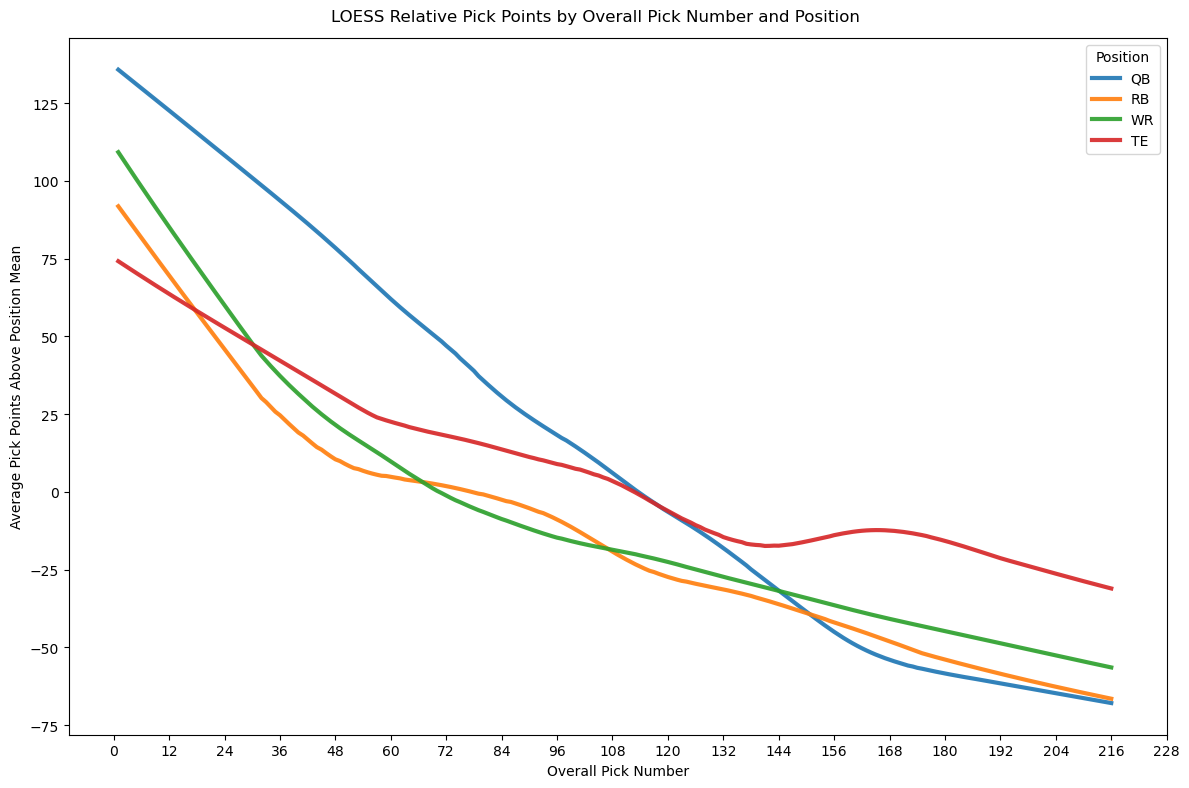

In [65]:
# Reset the index of the DataFrame
data_reset = data.reset_index()

# Center the data through the center of each dataset
positions = ['QB', 'RB', 'WR', 'TE']
for position in positions:
    center = data_reset[data_reset['position_name'] == position]['pick_points'].mean()
    data_reset.loc[data_reset['position_name'] == position, 'pick_points'] -= center

import statsmodels.api as sm

# Plot each position on the same plot
plt.figure(figsize=(12, 8))
plt.suptitle('LOESS Relative Pick Points by Overall Pick Number and Position')

positions = ['QB', 'RB', 'WR', 'TE']
for position in positions:
    # Calculate the LOESS curve
    lowess = sm.nonparametric.lowess(data_reset[data_reset['position_name'] == position]['pick_points'], 
                                     data_reset[data_reset['position_name'] == position]['overall_pick_number'], 
                                     frac=0.33)
    # Plot the LOESS curve
    sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], label=position, linewidth=3, alpha=0.90)

plt.ylabel('Average Pick Points Above Position Mean')
plt.xlabel('Overall Pick Number')
plt.xticks(np.arange(0, 240, 12))
plt.legend(title='Position')

plt.tight_layout()
plt.show()

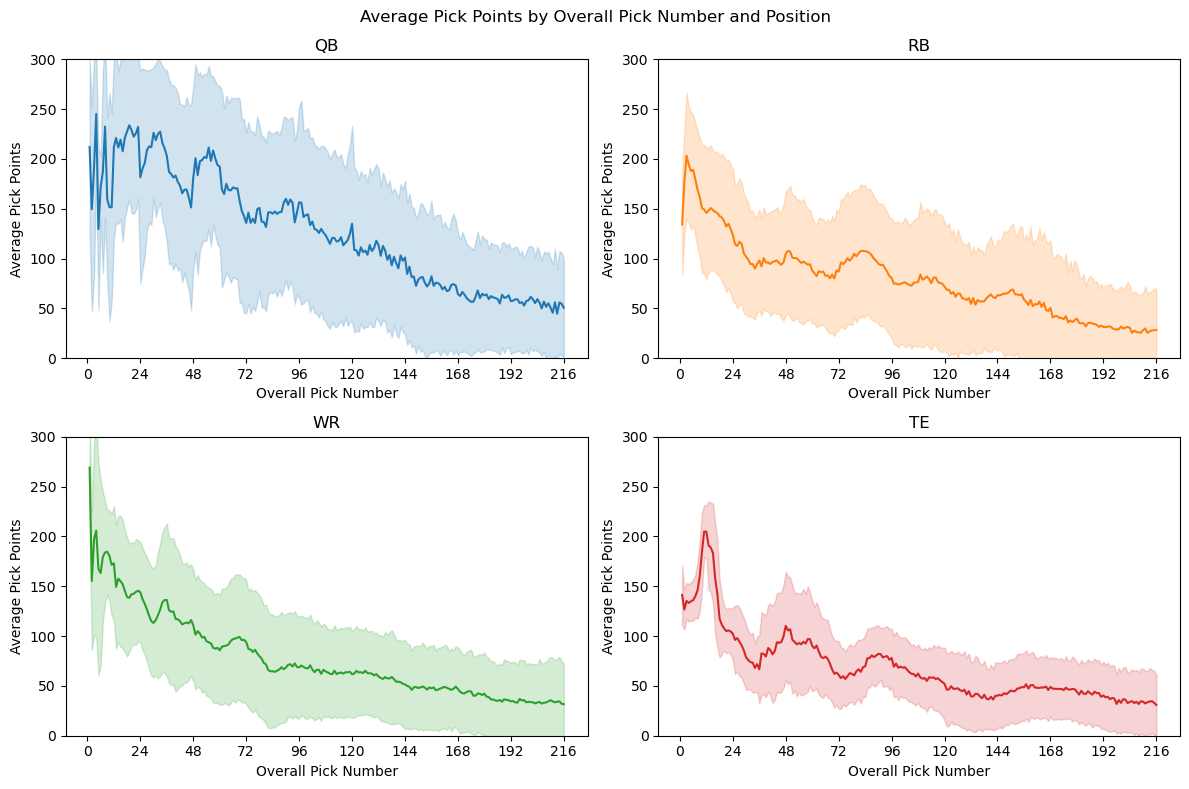

In [9]:
# Reset the index of the DataFrame
data_reset = data.reset_index()

# Get the standard seaborn color palette
colors = sns.color_palette()

# Plot each position
plt.figure(figsize=(12, 8))
plt.suptitle('Average Pick Points by Overall Pick Number and Position')

plt.subplot(2, 2, 1)
sns.lineplot(data=data_reset[data_reset['position_name'] == 'QB'], x='overall_pick_number', y='pick_points', ci='sd', color=colors[0])
plt.title('QB')
plt.ylabel('Average Pick Points')
plt.xlabel('Overall Pick Number')
plt.ylim(0, 300)
plt.xticks(np.arange(0, 240, 24))

plt.subplot(2, 2, 2)
sns.lineplot(data=data_reset[data_reset['position_name'] == 'RB'], x='overall_pick_number', y='pick_points', ci='sd', color=colors[1])
plt.title('RB')
plt.ylabel('Average Pick Points')
plt.xlabel('Overall Pick Number')
plt.ylim(0, 300)
plt.xticks(np.arange(0, 240, 24))

plt.subplot(2, 2, 3)
sns.lineplot(data=data_reset[data_reset['position_name'] == 'WR'], x='overall_pick_number', y='pick_points', ci='sd', color=colors[2])
plt.title('WR')
plt.ylabel('Average Pick Points')
plt.xlabel('Overall Pick Number')
plt.ylim(0, 300)
plt.xticks(np.arange(0, 240, 24))

plt.subplot(2, 2, 4)
sns.lineplot(data=data_reset[data_reset['position_name'] == 'TE'], x='overall_pick_number', y='pick_points', ci='sd', color=colors[3])
plt.title('TE')
plt.ylabel('Average Pick Points')
plt.xlabel('Overall Pick Number')
plt.ylim(0, 300)
plt.xticks(np.arange(0, 240, 24))

plt.tight_layout()
plt.show()

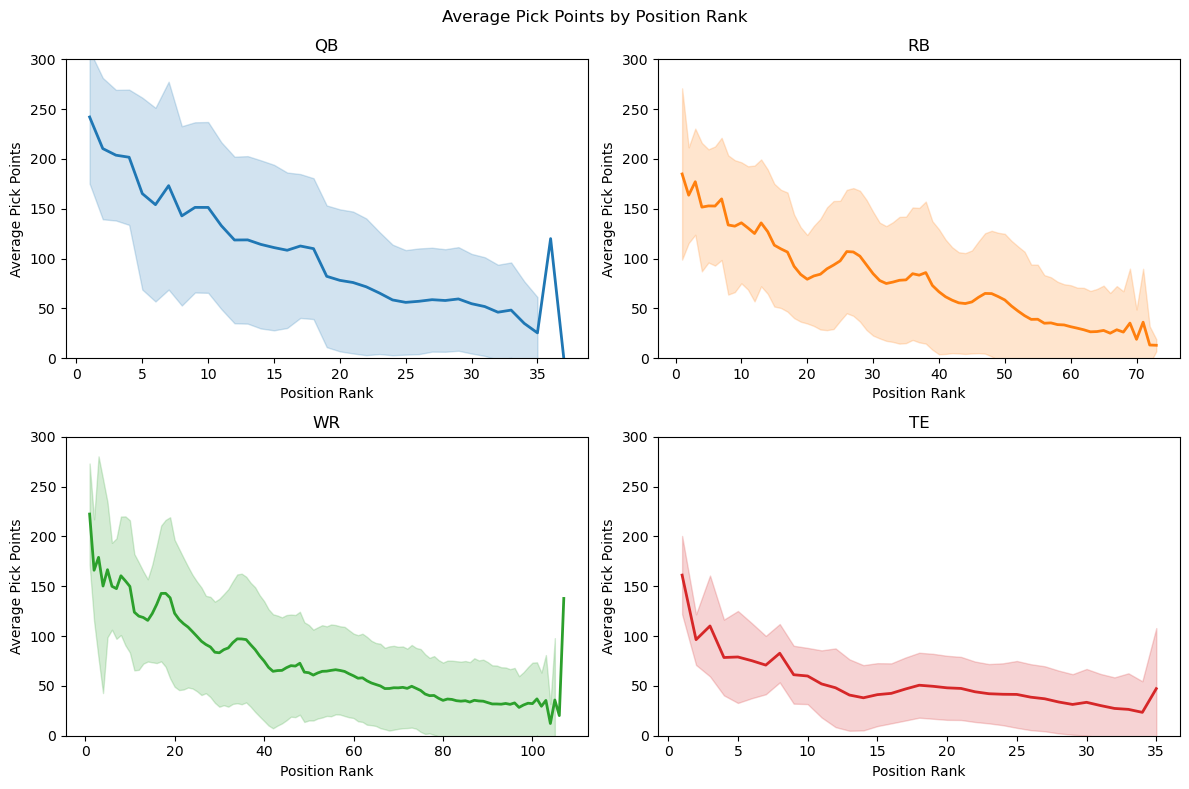

In [8]:
# Group by 'draft_id', 'position_name', 'pick_points' and 'overall_pick_number'
data_grouped = data.groupby(['draft_id', 'position_name', 'overall_pick_number', 'pick_points']).mean().reset_index()
data_grouped = data_grouped[['draft_id', 'position_name', 'overall_pick_number', 'pick_points']]
data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

# New column 'pos_rank' which is the rank of the 'position_name' in each 'draft_id'
# if lowest 'overall_pick_number' then rank is 1, if second lowest then rank is 2, and so on
data_grouped['pos_rank'] = data_grouped.groupby(['draft_id', 'position_name'])['overall_pick_number'].rank()

# Plot pos_rank against pick_points for each position_name
colors = sns.color_palette()
plt.figure(figsize=(12, 8))
plt.suptitle('Average Pick Points by Position Rank')

plt.subplot(2, 2, 1)
sns.lineplot(data=data_grouped[data_grouped['position_name'] == 'QB'], x='pos_rank', y='pick_points', color=colors[0], linewidth=2, ci='sd')
plt.title('QB')
plt.ylabel('Average Pick Points')
plt.xlabel('Position Rank')
plt.ylim(0, 300)

plt.subplot(2, 2, 2)
sns.lineplot(data=data_grouped[data_grouped['position_name'] == 'RB'], x='pos_rank', y='pick_points', color=colors[1], linewidth=2, ci='sd')
plt.title('RB')
plt.ylabel('Average Pick Points')
plt.xlabel('Position Rank')
plt.ylim(0, 300)

plt.subplot(2, 2, 3)
sns.lineplot(data=data_grouped[data_grouped['position_name'] == 'WR'], x='pos_rank', y='pick_points', color=colors[2], linewidth=2, ci='sd')
plt.title('WR')
plt.ylabel('Average Pick Points')
plt.xlabel('Position Rank')
plt.ylim(0, 300)

plt.subplot(2, 2, 4)
sns.lineplot(data=data_grouped[data_grouped['position_name'] == 'TE'], x='pos_rank', y='pick_points', color=colors[3], linewidth=2, ci='sd')
plt.title('TE')
plt.ylabel('Average Pick Points')
plt.xlabel('Position Rank')
plt.ylim(0, 300)

plt.tight_layout()
plt.show()

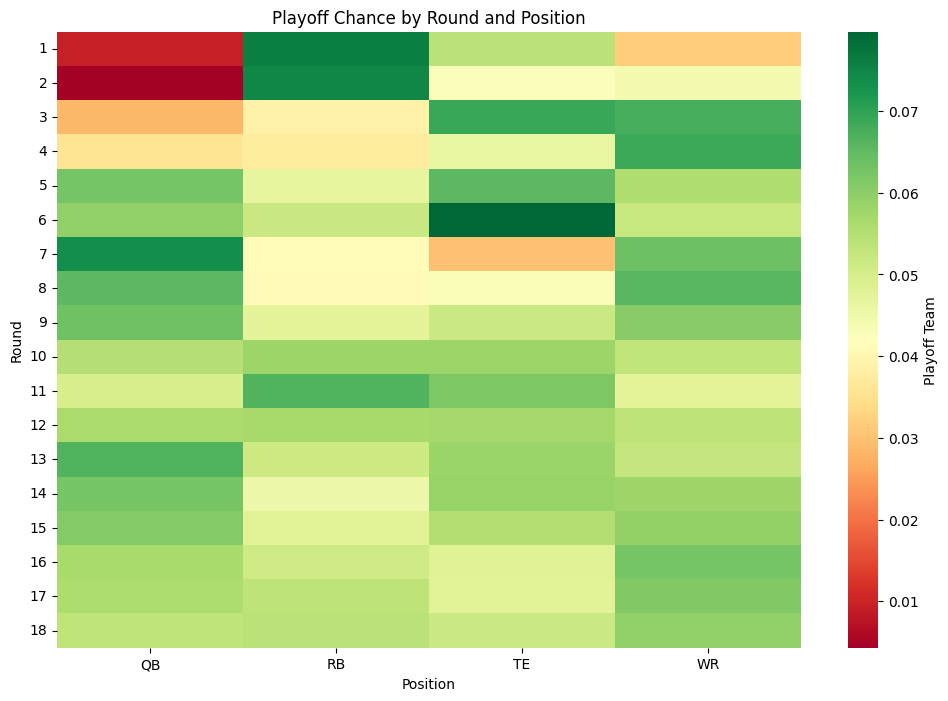

In [14]:
# Group by 'team_pick_number' and 'position_name'
df = data[["team_pick_number", "position_name", 'playoff_team']]
data_grouped = df.groupby(['team_pick_number', 'position_name']).mean().reset_index()

# New dataframe with 'team_pick_number' as index and 'position_name' as columns, and rows as 'playoff_team'
data_pivot = data_grouped.pivot(index='team_pick_number', columns='position_name', values='playoff_team')
data_pivot = data_pivot.drop(columns="FB")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_pivot, cmap='RdYlGn', cbar_kws={'label': 'Playoff Team'})
plt.title('Playoff Chance by Round and Position')
plt.xlabel('Position')
plt.ylabel('Round')
plt.yticks(rotation=0)
plt.show()

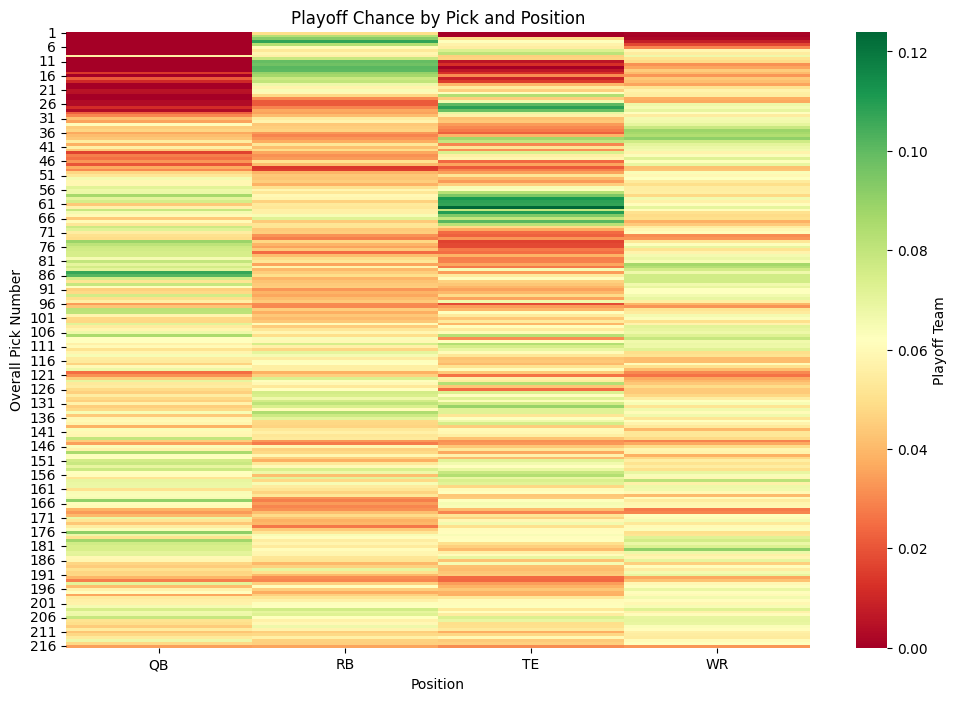

In [13]:
# Group by 'overall_pick_number' and 'position_name'
df = data[["overall_pick_number", "position_name", 'playoff_team']]
data_grouped = df.groupby(['overall_pick_number', 'position_name']).mean().reset_index()

# New dataframe with 'team_pick_number' as index and 'position_name' as columns, and rows as 'playoff_team'
data_pivot = data_grouped.pivot(index='overall_pick_number', columns='position_name', values='playoff_team')
data_pivot = data_pivot.drop(columns="FB")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_pivot, cmap='RdYlGn', cbar_kws={'label': 'Playoff Team'})
plt.title('Playoff Chance by Pick and Position')
plt.xlabel('Position')
plt.ylabel('Overall Pick Number')
plt.yticks(rotation=0)
plt.show()

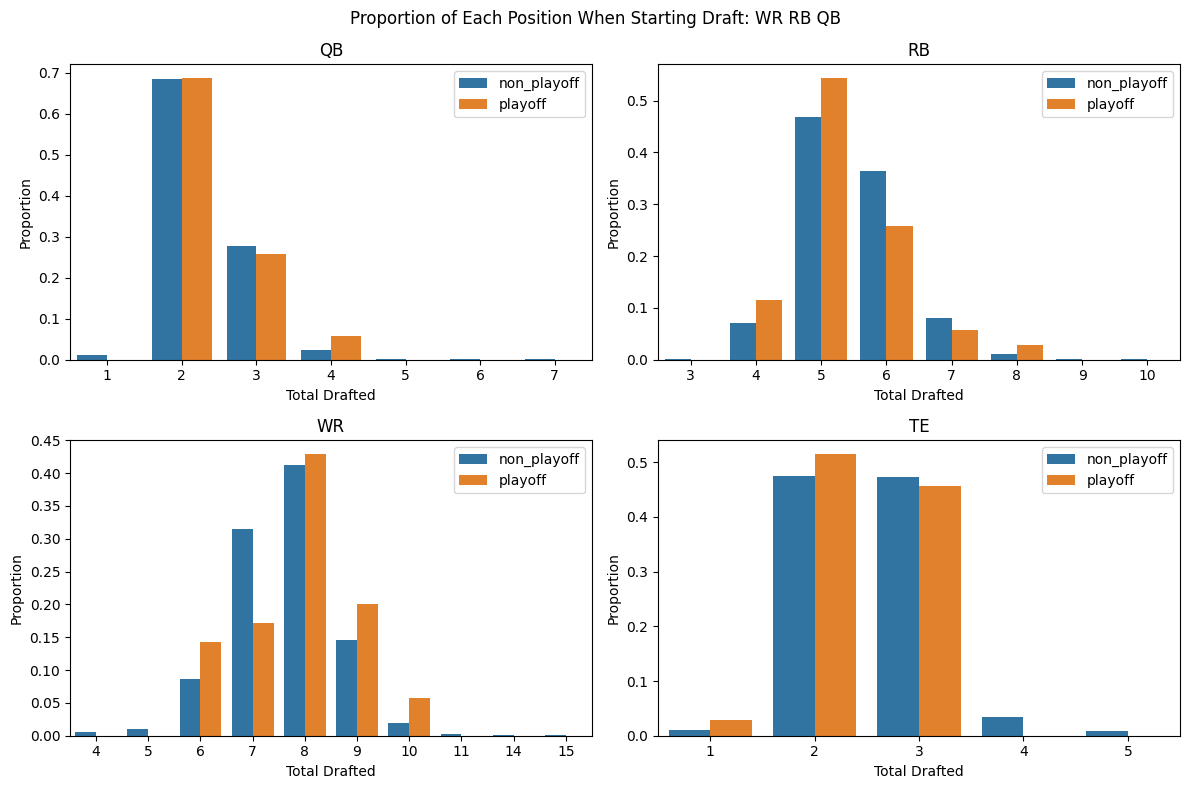

In [8]:
def starting(i, ii, iii):
    # Find teams with starting condition
    round_one = data[(data['team_pick_number'] == 1) & (data['position_name'] == i)]
    round_two = data[(data['team_pick_number'] == 2) & (data['position_name'] == ii)]
    round_three = data[(data['team_pick_number'] == 3) & (data['position_name'] == iii)]
    team_ids = list(set(round_one['team_id']) & set(round_two['team_id']) & set(round_three['team_id']))

    # Group by 'draft_id' 
    data_grouped = data.groupby(['team_id', 'playoff_team', 'team_pick_number', 'position_name']).mean(numeric_only=True).reset_index()

    # Group by 'draft_id','playoff_team', 'roster_points', 'position_name', and make new columns to cumsum the unique postion names
    data_grouped['QB'] = data_grouped['position_name'].apply(lambda x: 1 if x=='QB' else 0)
    data_grouped['RB'] = data_grouped['position_name'].apply(lambda x: 1 if x=='RB' else 0)
    data_grouped['WR'] = data_grouped['position_name'].apply(lambda x: 1 if x=='WR' else 0)
    data_grouped['TE'] = data_grouped['position_name'].apply(lambda x: 1 if x=='TE' else 0)

    data_grouped = data_grouped.groupby(['team_id', 'playoff_team', 'roster_points']).sum().reset_index()

    # If team_id is in team_ids then 'starting' == 1
    data_grouped['starting'] = data_grouped['team_id'].apply(lambda x: 1 if x in team_ids else 0)

    # Filter 'playoff_team'
    playoff = data_grouped[(data_grouped['playoff_team'] == 1) & (data_grouped['starting'] == 1)]
    non_playoff = data_grouped[(data_grouped['playoff_team'] == 0) & (data_grouped['starting'] == 1)]

    # Compute proportions of unique QB values
    qb_playoff = playoff['QB'].value_counts(normalize=True)
    qb_non_playoff = non_playoff['QB'].value_counts(normalize=True)
    rb_playoff = playoff['RB'].value_counts(normalize=True)
    rb_non_playoff = non_playoff['RB'].value_counts(normalize=True)
    wr_playoff = playoff['WR'].value_counts(normalize=True)
    wr_non_playoff = non_playoff['WR'].value_counts(normalize=True)
    te_playoff = playoff['TE'].value_counts(normalize=True)
    te_non_playoff = non_playoff['TE'].value_counts(normalize=True)

    # New df for proportions
    qb = pd.DataFrame({'non_playoff': qb_non_playoff, 'playoff': qb_playoff}).reset_index()
    rb = pd.DataFrame({'non_playoff': rb_non_playoff, 'playoff': rb_playoff}).reset_index()
    wr = pd.DataFrame({'non_playoff': wr_non_playoff, 'playoff': wr_playoff}).reset_index()
    te = pd.DataFrame({'non_playoff': te_non_playoff, 'playoff': te_playoff}).reset_index()

    # Reshape the dataframes
    qb_melt = qb.melt(id_vars='QB', var_name='Team Type', value_name='Proportion')
    rb_melt = rb.melt(id_vars='RB', var_name='Team Type', value_name='Proportion')
    wr_melt = wr.melt(id_vars='WR', var_name='Team Type', value_name='Proportion')
    te_melt = te.melt(id_vars='TE', var_name='Team Type', value_name='Proportion')

    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Proportion of Each Position When Starting Draft: {i} {ii} {iii}')

    sns.barplot(x='QB', y='Proportion', hue='Team Type', data=qb_melt, ax=ax[0, 0])
    ax[0, 0].set_title('QB')
    ax[0, 0].set_ylabel('Proportion')
    ax[0, 0].set_xlabel("Total Drafted")
    ax[0, 0].legend(loc="upper right")

    sns.barplot(x='RB', y='Proportion', hue='Team Type', data=rb_melt, ax=ax[0, 1])
    ax[0, 1].set_title('RB')
    ax[0, 1].set_ylabel('Proportion')
    ax[0, 1].set_xlabel("Total Drafted")
    ax[0, 1].legend(loc="upper right")

    sns.barplot(x='WR', y='Proportion', hue='Team Type', data=wr_melt, ax=ax[1, 0])
    ax[1, 0].set_title('WR')
    ax[1, 0].set_ylabel('Proportion')
    ax[1, 0].set_xlabel("Total Drafted")
    ax[1, 0].legend(loc="upper right")

    sns.barplot(x='TE', y='Proportion', hue='Team Type', data=te_melt, ax=ax[1, 1])
    ax[1, 1].set_title('TE')
    ax[1, 1].set_ylabel('Proportion')
    ax[1, 1].set_xlabel("Total Drafted")
    ax[1, 1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

#starting(i="WR", ii="RB", iii="QB")

In [20]:
starting(i="RB", ii="WR", iii="WR")

C:\Users\Jack\AppData\Local\Temp\ipykernel_37140\172943834.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby('team_id').apply(lambda x: x[['team_pick_number', 'position_name']].values.tolist())


TypeError: agg function failed [how->mean,dtype->object]

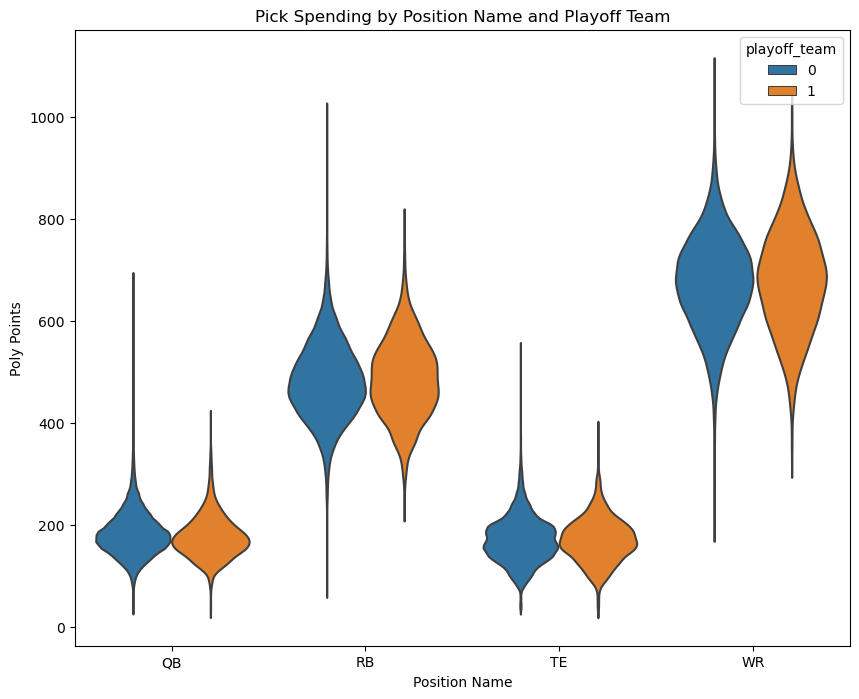

In [13]:
# Group by 'draft_id', 'pick_order', 'roster_points', 'playoff_team': compute average 'poly_points'
data_grouped = data.groupby(['team_id', 'pick_order', 'playoff_team', 'position_name']).sum().reset_index()
data_grouped = data_grouped.drop(columns=['overall_pick_number', 'pick_points', 'team_pick_number', 'projection_adp', 'roster_points'])
data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

# Bar Plot 'poly_points' by 'position_name' and 'playoff_team'
plt.figure(figsize=(10, 8))
sns.violinplot(data=data_grouped, x='position_name', y='poly_points', hue='playoff_team', inner=None)
plt.xlabel('Position Name')
plt.ylabel('Poly Points')
plt.title('Pick Spending by Position Name and Playoff Team')
plt.show()

In [92]:
def poly_rounds(i, e, l):
    # New column 'round_segment'
    data['round_segment'] = np.where(data['team_pick_number'] <= i, 'Initial',
                                        np.where((data['team_pick_number'] > i) & (data['team_pick_number'] <= e), 'Early',
                                                np.where((data['team_pick_number'] > e) & (data['team_pick_number'] <= l), 'Late', 'Final')))

    # Group by 'draft_id', 'pick_order', 'roster_points', 'playoff_team': compute average 'poly_points'
    data_grouped = data.groupby(['draft_id', 'pick_order', 'roster_points', 'playoff_team', 'position_name', 'round_segment']).sum().reset_index()
    data_grouped = data_grouped.drop(columns=['overall_pick_number', 'pick_points', 'projection_adp', 'team_pick_number'])
    data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == "FB"].index)

    # Define initial, early, late, final rounds
    initial = data_grouped[data_grouped['round_segment'] == 'Initial']
    early = data_grouped[data_grouped['round_segment'] == 'Early']
    late = data_grouped[data_grouped['round_segment'] == 'Late']
    final = data_grouped[data_grouped['round_segment'] == 'Final']

    # Define the order of the position levels
    position_order = ['QB', 'RB', 'WR', 'TE']

    # Bar Plot 'poly_points' by 'position_name' and 'playoff_team'
    plt.figure(figsize=(10, 8))
    plt.suptitle('Pick Spending by Position and Playoff Outcome', fontsize=14)

    plt.subplot(2, 2, 1)
    sns.violinplot(data=initial, x='position_name', y='poly_points', hue='playoff_team', order=position_order, inner=None)
    plt.xlabel('')
    plt.ylabel('Poly Points')
    plt.title('Initial Rounds')
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 2)
    sns.violinplot(data=early, x='position_name', y='poly_points', hue='playoff_team', order=position_order, inner=None)
    plt.xlabel('')
    plt.ylabel('Poly Points')
    plt.title('Early Rounds')
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 3)
    sns.violinplot(data=late, x='position_name', y='poly_points', hue='playoff_team', order=position_order, inner=None)
    plt.xlabel('')
    plt.ylabel('Poly Points')
    plt.title('Late Rounds')
    plt.legend(loc='upper right')
    
    plt.subplot(2, 2, 4)
    sns.violinplot(data=final, x='position_name', y='poly_points', hue='playoff_team', order=position_order, inner=None)
    plt.xlabel('')
    plt.ylabel('Poly Points')
    plt.title('Final Rounds')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

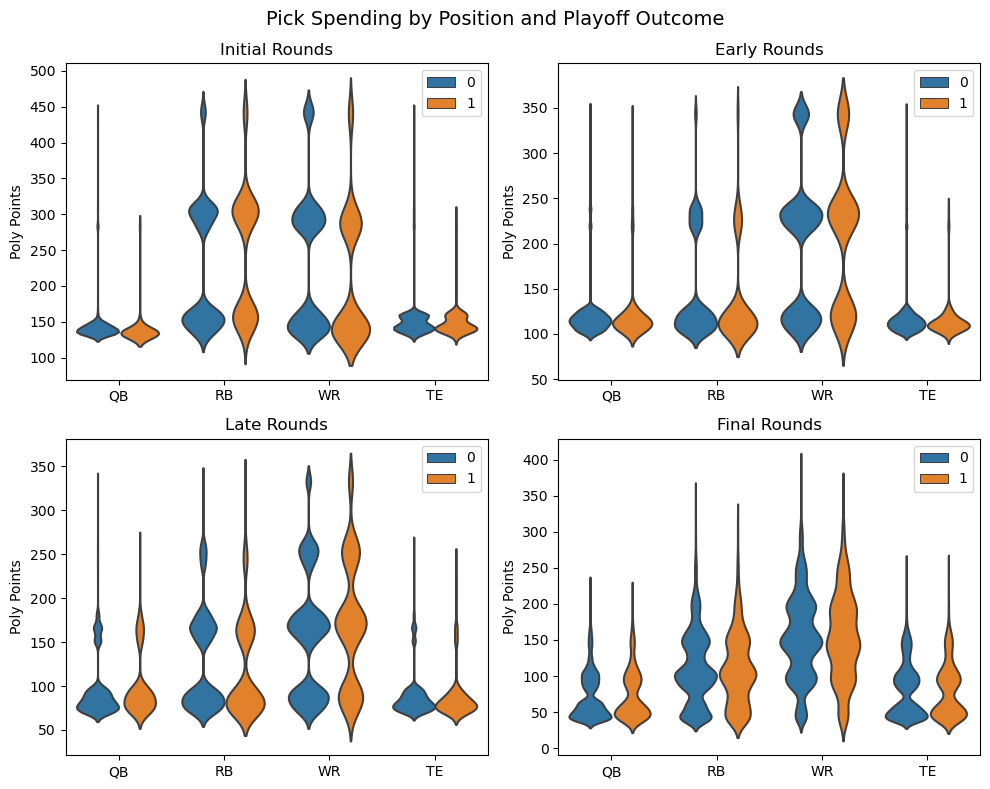

In [93]:
poly_rounds(i=3, e=6, l=10)

In [18]:
def rolling_poly(pos):
    # Percent of draft_id select a qb at all overall_pick_numbers
    df = data[data['position_name'] == pos]
    df = df.groupby(['team_id', 'overall_pick_number', 'playoff_team']).count().reset_index()
    df = df.groupby(['overall_pick_number', 'playoff_team']).count().reset_index()

    # Separate by 'playoff_team'
    playoff = df[df['playoff_team'] == True]
    non_playoff = df[df['playoff_team'] == False]

    playoff.loc[:, 'percent'] = playoff['team_id']/playoff['team_id'].sum()
    non_playoff.loc[:, 'percent'] = non_playoff['team_id']/non_playoff['team_id'].sum()

    # Define the window size
    window_size = 5

    # Calculate the rolling average
    playoff.loc[:, 'percent_rolling'] = playoff['percent'].rolling(window_size).mean()
    non_playoff.loc[:, 'percent_rolling'] = non_playoff['percent'].rolling(window_size).mean()

    # Plot percent of draft_id select a qb at all overall_pick_numbers for playoff teams with rolling average
    plt.figure(figsize=(10, 5))
    plt.plot(playoff['overall_pick_number'], playoff['percent_rolling'], color='blue', label='Playoff Teams', linewidth=2)

    # Plot percent of draft_id select a qb at all overall_pick_numbers for non-playoff teams with rolling average
    plt.plot(non_playoff['overall_pick_number'], non_playoff['percent_rolling'], color='red', label='Non-Playoff Teams', linewidth=2)

    plt.xlabel('Overall Pick Number')
    plt.ylabel(pos + ' Pick Frequency')
    plt.title('Percent of Selections for ' + pos + ' (Rolling Average)')
    plt.xticks(np.arange(0, 240, 24))
    plt.legend()
    plt.show()

C:\Users\Jack\AppData\Local\Temp\ipykernel_15108\353481835.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playoff.loc[:, 'percent'] = playoff['team_id']/playoff['team_id'].sum()
C:\Users\Jack\AppData\Local\Temp\ipykernel_15108\353481835.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playoff.loc[:, 'percent'] = non_playoff['team_id']/non_playoff['team_id'].sum()
C:\Users\Jack\AppData\Local\Temp\ipykernel_15108\353481835.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

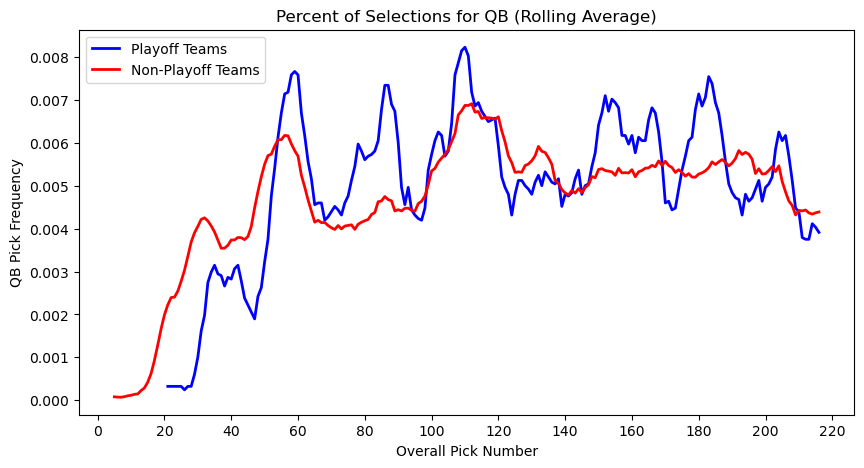

In [19]:
rolling_poly('QB')

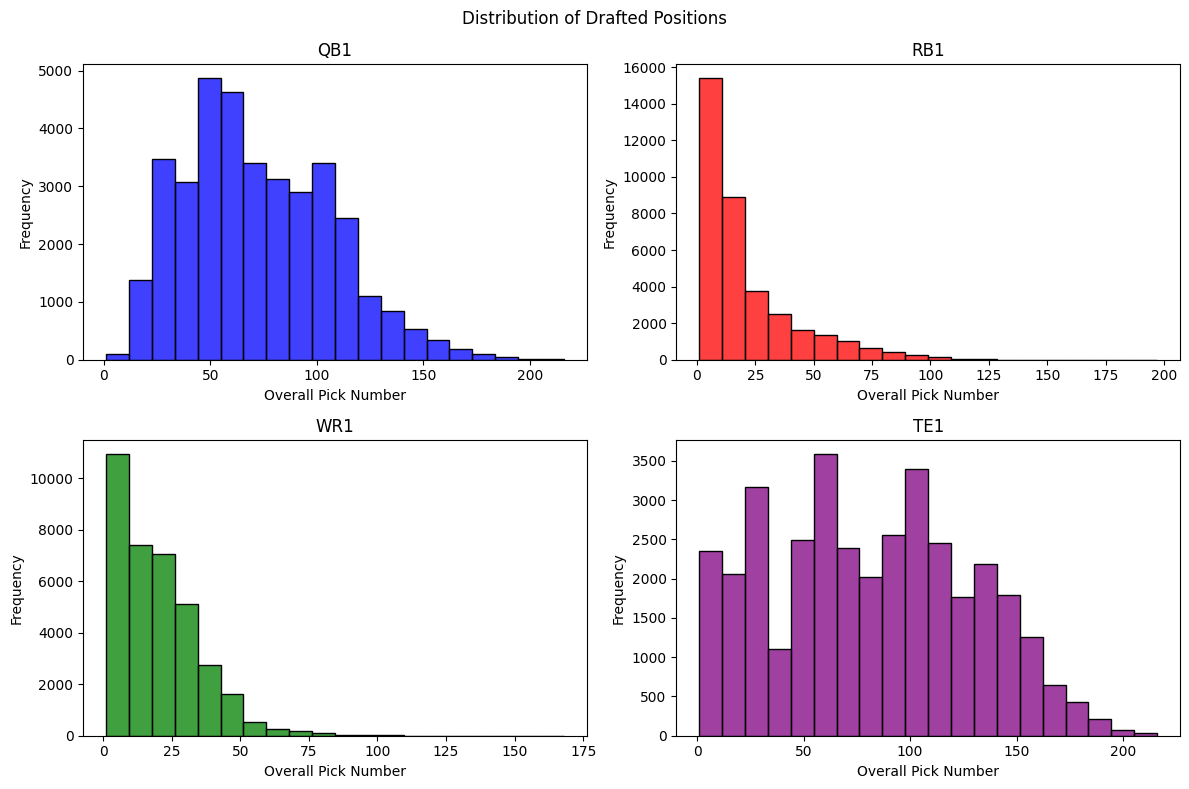

In [8]:
# Transform data into the selection at which each team drafted each position
def ordinal_ranks(data, drop_columns=False):
    # Group by 'draft_id', 'position_name', 'pick_points' and 'overall_pick_number'
    df = data[['team_id', 'position_name', 'overall_pick_number', 'pick_points']]
    roster_points = data[['team_id', 'roster_points']].drop_duplicates()

    data_grouped = df.groupby(['team_id', 'position_name', 'overall_pick_number', 'pick_points']).mean().reset_index()
    data_grouped = data_grouped[['team_id', 'position_name', 'overall_pick_number', 'pick_points']]
    data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

    # New column 'pos_rank' which is the rank of the 'position_name' in each 'draft_id'
    # if lowest 'overall_pick_number' then rank is 1, if second lowest then rank is 2, and so on
    data_grouped['pos_rank'] = data_grouped.groupby(['team_id', 'position_name'])['overall_pick_number'].rank()

    # New column pos_team_rank which is position_name + pos_rank
    data_grouped['pos_team_rank'] = data_grouped['position_name'] + data_grouped['pos_rank'].astype(str)

    # Pivot the data so that position names are columns, and overall pick numbers are rows
    data_grouped = data_grouped.pivot(index='team_id', columns='pos_team_rank', values='overall_pick_number').reset_index()

    # Drop columns below 5 percent full
    if drop_columns == True:
        data_grouped = data_grouped.dropna(thresh=0.05*len(data_grouped), axis=1)

    # Fill NaN values with 432
    data_grouped = data_grouped.fillna(432)

    # Merge with 'roster_points'
    data_grouped = data_grouped.merge(roster_points, on='team_id')
    
    # Drop 'team_id' column
    data_grouped = data_grouped.drop(columns=['team_id'])

    return data_grouped

df = ordinal_ranks(data, drop_columns=True)

# Plot the distribution of each position
plt.figure(figsize=(12, 8))
plt.suptitle('Distribution of Drafted Positions')

plt.subplot(2, 2, 1)
sns.histplot(df['QB1.0'], bins=20, color='blue')
plt.title('QB1')
plt.xlabel('Overall Pick Number')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df['RB1.0'], bins=20, color='red')
plt.title('RB1')
plt.xlabel('Overall Pick Number')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df['WR1.0'], bins=20, color='green')
plt.title('WR1')
plt.xlabel('Overall Pick Number')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(df['TE1.0'], bins=20, color='purple')
plt.title('TE1')
plt.xlabel('Overall Pick Number')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
df = ordinal_ranks(data, drop_columns=False)
top10 = df['roster_points'].quantile(0.9)
bottom10 = df['roster_points'].quantile(0.1)

# Filter the top 10% and bottom 10% of teams
top = df[df['roster_points'] >= top10]
bottom = df[df['roster_points'] <= bottom10]

# Average the top 10% and bottom 10% of teams
top = top.mean().reset_index()
bottom = bottom.mean().reset_index()

# Find the difference between the top 10% and bottom 10% of teams
diff = top.merge(bottom, on='index')
diff['difference'] = diff['0_x'] - diff['0_y']

diff

,index,0_x,0_y,difference
0,QB1.0,70.265703,69.366315,0.899389
1,QB2.0,143.050584,139.824069,3.226515
2,QB3.0,330.942190,317.441356,13.500834
3,QB4.0,425.852418,419.175097,6.677321
4,QB5.0,431.462201,430.165092,1.297110
5,QB6.0,432.000000,431.857699,0.142301
6,QB7.0,432.000000,431.935242,0.064758
7,QB8.0,432.000000,431.938299,0.061701
8,RB1.0,23.614230,21.707337,1.906893
9,RB10.0,431.877988,431.933852,-0.055864
